<a href="https://colab.research.google.com/github/c820306/Alpha_camp_recommentation/blob/main/Week3%EF%BC%9ACollaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 基礎建設

In [67]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [68]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-09 03:19:15--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.1’

All_Beauty.csv.1    100%[===================>]  14.78M  44.5MB/s    in 0.3s    

2022-01-09 03:19:16 (44.5 MB/s) - ‘All_Beauty.csv.1’ saved [15499476/15499476]

--2022-01-09 03:19:16--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.1’

meta_All_Beauty.jso 100%[===================>]   9.85M  34.8MB/s    in 0.3s   

In [69]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [70]:
# metadata = getDF('./meta_All_Beauty.json.gz')
# ratings = pd.read_csv('./All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [71]:
metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


In [72]:
ratings.head(3)

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800


In [73]:
print(ratings.shape)

(371345, 4)


## 資料整理與清洗

### 調整日期格式

In [74]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

### 發現客戶曾多次買同個商品

* 發現ratings有同一個客戶有同天同產品評價分數相同的狀況： 共9,070筆

In [75]:
print(f"repeated rating of product:  {ratings.shape[0]- ratings.drop_duplicates().shape[0]}")


repeated rating of product:  9070


* 排除重複評價資料

In [76]:
ratings = ratings.drop_duplicates()

In [77]:
df = ratings.groupby(['reviewerID','asin'],as_index=False).agg(count=('reviewerID','count'))
repeated_purchase_product_users = df[ df['count']> 1]['reviewerID'].unique()
repeated_purchase_product = df[df['count']>1]['asin'].unique()

* 共603位客戶曾購買同一個商品(not on same day), 被重複購買商品數有153個
* 重複評價分數會影響後續user_to_item、item_to_user，採用最近的商品評價，共670筆排除

In [78]:
print(f"the number of user for repeated purchase the same product: {len(repeated_purchase_product_users)}")
print(f"the number of product for being repeated purchased: {len(repeated_purchase_product)}")

the number of user for repeated purchase the same product: 603
the number of product for being repeated purchased: 153


In [79]:
df = ratings[ratings['reviewerID'].isin(repeated_purchase_product_users)&
             ratings['asin'].isin(repeated_purchase_product)
            ].sort_values(['reviewerID','asin','DATE'], ascending=[True,True,False])
df

,asin,reviewerID,overall,unixReviewTime,DATE
12244,B00011QUDE,A108DY5IC7OVWT,3.0,1473552000,2016-09-11
12245,B00011QUDE,A108DY5IC7OVWT,1.0,1473552000,2016-09-11
74633,B001E5PLCM,A10CKOFTMAV45W,3.0,1356393600,2012-12-25
74634,B001E5PLCM,A10CKOFTMAV45W,4.0,1355270400,2012-12-12
90436,B002OITLG0,A10DOJIAIUIAEB,5.0,1519948800,2018-03-02
...,...,...,...,...,...
226967,B01AAVIO38,AZBLP8S3CHH3,4.0,1460160000,2016-04-09
193603,B00W259T7G,AZBOC8H7QQGJC,3.0,1436313600,2015-07-08
193749,B00W259T7G,AZBOC8H7QQGJC,4.0,1422489600,2015-01-29
194060,B00W259T7G,AZWIAYHWL2FWE,4.0,1395100800,2014-03-18


In [80]:
keep = df.drop_duplicates(subset=['asin','reviewerID'],keep='first').index
repeated_drop_set = set(df.index) - set(keep)
keep_list = list(set(ratings.index) - repeated_drop_set)

print(f"the number of repeated purchase not recently--> delete: {len(repeated_drop_set)}")

the number of repeated purchase not recently--> delete: 670


In [81]:
ratings = ratings.loc[keep_list]
ratings.shape

(361605, 5)

## 資料切分

In [82]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [83]:
print(ratings_trainings.shape)
print(ratings_testings.shape)

(361012, 5)
(590, 5)


## EDA

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

### 整體客戶之評分分布

- 75.8% rating分數 >= 4，客戶的商品評分都給蠻高的

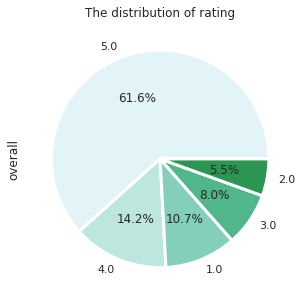

In [85]:
colors = sns.color_palette("BuGn")[:5]
fig, ax = plt.subplots(figsize=(5, 5))
ax = ratings['overall'].value_counts().plot.pie(autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       colors = colors )
ax.set_title("The distribution of rating")
plt.show()

In [86]:
ratings['overall'].value_counts().to_frame()

,overall
5.0,222891
4.0,51411
1.0,38539
3.0,28875
2.0,19889


### 客戶評分分布 vs 時間

* 綜觀時間維度，其分佈與整體差異不大，4分以上為主要佔比(70~80%)

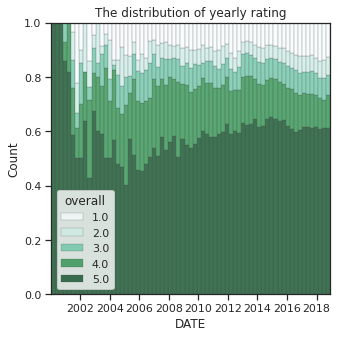

In [87]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(
    data = ratings,
    x="DATE", hue="overall",
    multiple="fill",
    palette="BuGn",
    edgecolor=".3",
    linewidth=.2,
    binwidth = (100)
)
ax.set_title('The distribution of yearly rating')
plt.show()

### 每個客戶之購買次數分佈

* 客戶主要購買次數為1次（90.9%)

In [88]:
ratings['reviewerID'].value_counts().to_frame()

,reviewerID
A2GJX2KCUSR0EI,24
A1KSC91G9AIY2Z,22
AENH50GW3OKDA,20
A22CW0ZHY3NJH8,18
A1UQBFCERIP7VJ,16
...,...
A1NX5Z793GWUDM,1
A2Q1T0ZGACGKIG,1
A3STTBERCK0UJ1,1
A9RN5CTWXK83Y,1


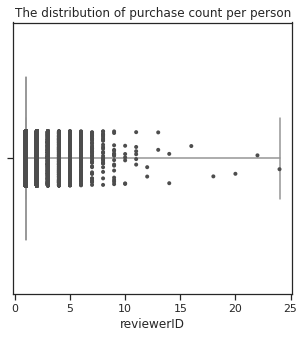

In [89]:
def range_tag(x):
    if x == 1:
        return '1 time'
    elif x == 2:
        return '2 times'
    elif x > 2 and x <=5 :
        return '3~5 times'
    else:
        return 'more than 5 times' 
    
fig, ax = plt.subplots(figsize=(5, 5))
reviewerID_count = ratings['reviewerID'].value_counts().to_frame()

ax = sns.boxplot(x='reviewerID', data=reviewerID_count,
            whis=[0, 100], width=.6, palette="vlag"
                )
sns.stripplot(x= 'reviewerID', data=reviewerID_count,
              size=4, color=".3", linewidth=0)

ax.set_title('The distribution of purchase count per person')
plt.show()

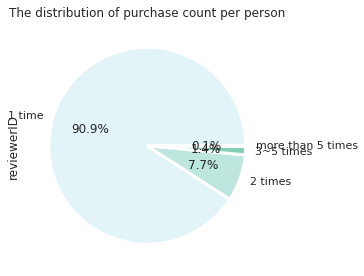

In [90]:
colors = sns.color_palette("BuGn")[:5]
reviewerID_count_df = reviewerID_count['reviewerID'].apply(range_tag).value_counts()
ax = reviewerID_count_df.plot.pie(autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, colors=colors)
ax.set_title('The distribution of purchase count per person', fontsize=12)
plt.tight_layout()

### 每位客戶購買次數分佈 vs 時間

* 從2008年後開始明顯有客戶購買3次以上，但2016年開始客戶購買之次數開始有走下坡趨勢

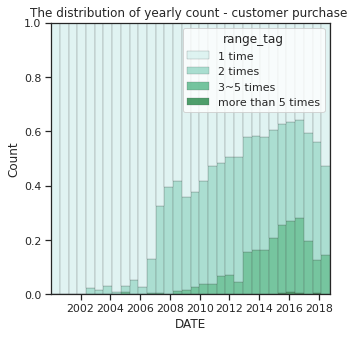

In [91]:
df = ratings.groupby(['DATE','reviewerID'], as_index=False).agg(count =('reviewerID','count'))
df['range_tag'] = df['count'].apply(range_tag)
df = df.groupby(['DATE','range_tag'], as_index=False).agg(count =('range_tag','count'))

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(
    data = df,
    x="DATE", hue="range_tag",
    multiple="fill",
    palette="BuGn",
    edgecolor=".3",
    linewidth=.2,
)

ax.set_title('The distribution of yearly count - customer purchase ')
plt.show()

### 整體商品之購買次數分佈

* 每個商品總購買次數區間主要落在1～2000之間

In [107]:
asin_count = ratings['asin'].value_counts().to_frame().reset_index()
asin_count[:10]

,index,asin
0,B000FOI48G,8656
1,B000GLRREU,8341
2,1620213982,4791
3,B001QY8QXM,4505
4,B01DKQAXC0,4240
5,B006IB5T4W,2789
6,B00W259T7G,2603
7,B00005JS5C,2249
8,B00VF344X0,1964
9,B0067F28ZW,1850


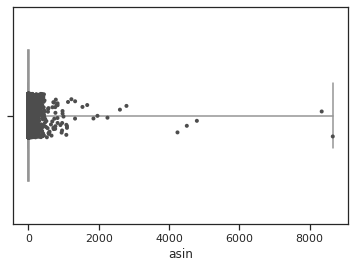

In [92]:
ax = sns.boxplot(x='asin', data=asin_count,
            whis=[0, 100], width=.6, palette="vlag"
                )
sns.stripplot(x='asin', data=asin_count,
              size=4, color=".3", linewidth=0)


In [120]:
# def range_tag(x):
#     if x > 0 and x <=10:
#         return '1~10'
#     elif x > 10 and x <=50 :
#         return '11~50'
#     elif x > 50 and x <=100 :
#         return '50~100'
#     elif x > 100 and x <=300 :
#         return '100~300'
#     elif x > 300 and x <=1000 :
#         return '300~1000'
#     elif x > 1000 and x <=4000 :
#         return '1000~4000'
#     else:
#         return 'more than 4000' 
              
# asin_count['range_tag']= asin_count['asin'].apply(range_tag)
# asin_count['range_tag'].value_counts()

1~10              28038
11~50              3435
50~100              571
100~300             411
300~1000            111
1000~4000            15
more than 4000        5
Name: range_tag, dtype: int64

In [126]:
def range_tag(x):
    if x == 1:
        return '1 time'
    elif x == 2:
        return '2 times'
    elif x > 2 and x <=5 :
        return '3~5 times'
    elif x > 5 and x <=10 :
        return '6~10 times'
    elif x > 10 and x <=15 :
        return '11~15 times'
    elif x > 15 and x <=20 :
        return '16~20 times'
    else:
        return 'more than 21 times' 
              
asin_count['range_tag']= asin_count['asin'].apply(range_tag)
asin_count['range_tag'].value_counts()

1 time                13503
3~5 times              6059
2 times                5409
6~10 times             3067
more than 21 times     2609
11~15 times            1257
16~20 times             682
Name: range_tag, dtype: int64

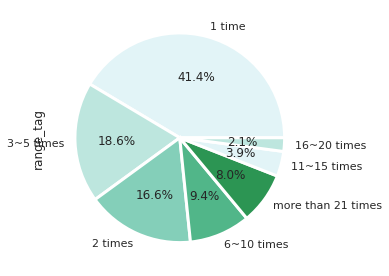

In [127]:
colors = sns.color_palette("BuGn")[:5]
asin_count['range_tag'].value_counts().plot.pie(autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, colors=colors)
ax.set_title('The distribution of purchase count per person', fontsize=12)
plt.tight_layout()

In [ ]:
colors = sns.color_palette("BuGn")[:5]
reviewerID_count_df = reviewerID_count['reviewerID'].apply(range_tag).value_counts()
ax = reviewerID_count_df.plot.pie(autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, colors=colors)
ax.set_title('The distribution of purchase count per person', fontsize=12)
plt.tight_layout()

### 商品的購買次數分佈 vs 時間

* 每月商品購買次數主要1~2次（約佔80%)

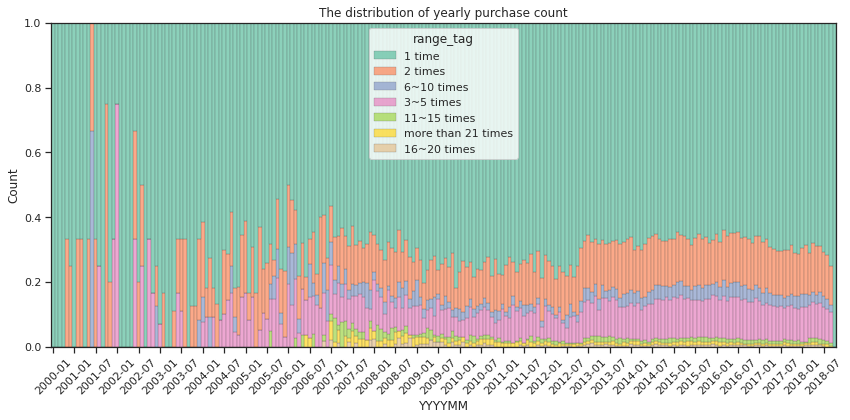

In [135]:
from datetime import datetime 
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

def range_tag(x):
    if x == 1:
        return '1 time'
    elif x == 2:
        return '2 times'
    elif x > 2 and x <=5 :
        return '3~5 times'
    elif x > 5 and x <=10 :
        return '6~10 times'
    elif x > 10 and x <=15 :
        return '11~15 times'
    elif x > 15 and x <=20 :
        return '16~20 times'
    else:
        return 'more than 21 times' 

ratings['YYYYMM'] = ratings['DATE'].dt.strftime('%Y-%m')
df = ratings.groupby(['YYYYMM','asin'], as_index=False).agg(count =('asin','count'))
df['range_tag'] = df['count'].apply(range_tag)
df['range_tag'] = df['count'].apply(lambda x : range_tag(x))

tickspacing=3
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(
    data = df,
    x="YYYYMM", hue="range_tag",
    multiple="fill",          
    palette="Set2",
    edgecolor=".3",
    linewidth=.2,
    binwidth = (500)
)

ax.set_title('The distribution of yearly purchase count')
ax.xaxis.set_major_locator(MultipleLocator(6))
ax.tick_params(axis='x', labelrotation=45 )
plt.tight_layout()
plt.show()

### 評價與銷量關係

* 商品平均評價越高，不一定與商品銷量有正向或負向關係，因此決定評價不納入相似度篩選條件

In [33]:
df = ratings.groupby(['asin'],as_index=False).agg(sale_count=('asin','count'), avg_overall=('overall','mean'))
df = df[df['sale_count']<=1000]

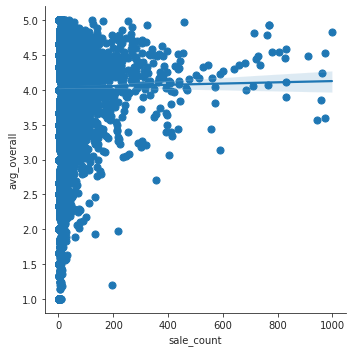

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x="sale_count", y="avg_overall", data=df,
           scatter_kws={"s": 50, "alpha": 1})


## User-based：產生推薦

In [35]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender(training_data, users=[], k=10):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3   
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating
    
    print("total items : ", len(item_to_users))

    # prepare data of computing user similarity
    # generate pre_user_similarity dict
    # {
    #   'user1': {
    #       'user2': [xy, xx, yy ],
    #.      'user3': [xy, xx, yy ]...
    #   }...
    # }
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else: # 有當迴圈裡沒有遇到 break 時，else 塊才會執行，當最後一個similarlity比target_similarity會執行
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order

    recommendation = {}
    for user in users:  # testing data user
        if user in user_similarity: #if testing in user_similarity
            sim_users = user_similarity[user] #[(dst_user, similarity),(dst_user, similarity)...]
            recommended_items = []
            recommended_items_set = set() 
            user_have_rated = set(user_to_items[user])  #{item1, item2, ...} 避免key重複，用戶評的商品清單
            stop_recommend = False
            for sim_user, _ in sim_users: #[(dst_user, similarity),(dst_user, similarity)...]
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1]) #user_to_items針對用戶商品的評分，由小排到大，[(item1:1),(item2:2)...]
                for item, rating in items_from_sim_user: #item, _ --> item, rating
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k: #recommended_items_set why not?
                        stop_recommend = True
                        break
                if stop_recommend:
                    break
            recommendation[user] = recommended_items
        else:
            recommendation[user] = []
    return recommendation

ratings_by_user = recommender(ratings_trainings, users)

total users before filtering:  323489
total users  after filtering:  4793
total items :  4853


## User-based：結果評估

In [36]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
            if len(set(ratings_by_user[d])) > 0:
                if len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))> 0:
                    print(f'user: {d} , Match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()
                else: 
                    print(f'user: {d} , Not match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()

    score = total / len(ratings_testings)
    return score

score = evaluate(ratings_testings_by_user, ratings_by_user)

print(f"The evaluation result is {score}")

user: A1SA3N793WT2LM , Not match!!!
recommendation:  ['B0007QKY80', 'B0001TMDF0', 'B0021YV3C2', 'B01BZV6VVY', 'B015ZVFK1W', 'B019Z9JUC0', 'B019Z9L8PW', 'B00NPJVLYW', 'B00CR6X0IY', 'B00L5E74VS']
real buy:  ['B01GAFCQOQ']

user: ACE1ZIOI3U6PY , Not match!!!
recommendation:  ['B00PMRE5A2', 'B00QHX7NT0', 'B01E7UKR38', 'B005IZD7BG', 'B000067E30', 'B006WZ9ZHQ']
real buy:  ['B01GOSELHE']

user: ASGIVOW34XNQS , Not match!!!
recommendation:  ['1620213982', 'B000KNELAW', 'B01DJI7796', 'B00006IGL2', 'B0001WXTPA', 'B0002JHI1I', 'B00120VWTK', 'B01DEDYWD0', 'B00021DJ32', 'B003I5SDJO']
real buy:  ['B01CGPN2D8']

The evaluation result is 0.0


In [37]:
print(f'{len([user for user in ratings_by_user if len(ratings_by_user[user])>0 ])} users have recommendations')

3 users have recommendations


## user-based結果分析

In [38]:
users_38_df = ratings_trainings[ratings_trainings['reviewerID'].isin(ratings_testings['reviewerID'])]
users_38_user = users_38_df['reviewerID'].unique()

In [39]:
print(f"First, among {len(ratings_by_user)} testing users, there are only {len(users_38_user)} user have purchase records between 2000 and 2018.")

First, among 584 testing users, there are only 38 user have purchase records between 2000 and 2018.


In [40]:
users_38_df = users_38_df.groupby(['reviewerID']).agg(list).reset_index()[['reviewerID','asin']]
users_38_df['count'] = users_38_df['asin'].apply(lambda x : len(x))

In [41]:
users_38_df.head(10)

,reviewerID,asin,count
0,A13JU88JAHN72I,[B009YDVB6Q],1
1,A16Y7V1CZCWKFV,[B015ZOWER2],1
2,A19503XX7GU6J2,"[B019Z9LD98, B019Z9LAPK]",2
3,A1EY751AUVO5NZ,[B01ENDFXJW],1
4,A1PR178735XC70,[B00NNLURMY],1
5,A1SA3N793WT2LM,"[B0054H0NZ6, B007EITOSK, B0075OYLKY, B012TQ6AXS]",4
6,A1TP9JHTIY468V,"[B01E6NITSG, B01CTKQL56]",2
7,A1UAOE8KO7Q1DZ,[B006NXZ7TC],1
8,A1WEFBEJ7OHSVZ,[B002OITLG0],1
9,A1WSZED2O5MA5T,[B000WYJTZG],1


In [42]:
print(f"Secondly, {len(users_38_user)} users have purchased, however 92.1% users purchased less than 3 times")

Secondly, 38 users have purchased, however 92.1% users purchased less than 3 times


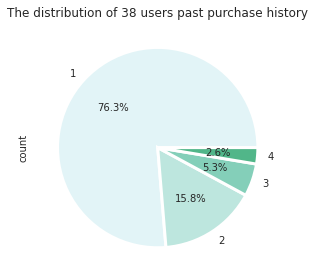

In [43]:
colors = sns.color_palette("BuGn")[:5]
ax = users_38_df['count'].value_counts().plot(kind='pie',autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, colors=colors)
ax.set_title('The distribution of 38 users past purchase history', fontsize=12)
plt.tight_layout()

In [44]:
print(f"Therefore, only {len(users_38_df[users_38_df['count']>2]['reviewerID'])} users have recommendations, but score is {score}, which doesn't perform well.")


Therefore, only 3 users have recommendations, but score is 0.0, which doesn't perform well.


#### Conclusion

* User-based推薦準度為0%
* 多數使用者購買次數主要落在3次以下，導致過濾排除購買次數小於3項的使用者時，多數使用者會被排除掉，同時也導致有成功被推薦的使用者，其產品推薦難達到10個商品推薦數，造成使用user-based無法有較佳成效


## Item-based產生推薦

In [45]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender(ratings_trainings, users=[], k=50):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in ratings_trainings.iterrows():
        
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

#     print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation    

ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

data converted
data inverted
sim data prepared


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00BWIT33Y'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B000EE9XYG',
  'B007SA3AUW',
  'B000FVHRXC',
  'B001U4RGOS',
  'B01CRWLLX8',
  'B004E4GHRS',
  'B006IB5T4W',
  'B00B0SA1SC',
  'B00JYGWWIO',
  'B00L88S190',
  'B00X7

## Item-based結果評估

In [46]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
            
            if len(set(ratings_by_user[d])) > 0:
                if len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))> 0:
                    print(f'user: {d} , Match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()
                else: 
                    print(f'user: {d} , Not match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()

    score = total / len(ratings_testings)
    return score

score = evaluate(ratings_testings_by_user, ratings_by_user)
print(f"The evaluation result is {score}")

user: A13JU88JAHN72I , Not match!!!
recommendation:  ['B00BWIT33Y']
real buy:  ['B017I6B6GK']

user: A16Y7V1CZCWKFV , Not match!!!
recommendation:  ['B000EE9XYG', 'B007SA3AUW', 'B000FVHRXC', 'B001U4RGOS', 'B01CRWLLX8', 'B004E4GHRS', 'B006IB5T4W', 'B00B0SA1SC', 'B00JYGWWIO', 'B00L88S190', 'B00X7G1CII', 'B00XC8OIDC', 'B00M8RRUSS', 'B00NV5QEEC', 'B00NV6DMG4', 'B00X3T6FEU', 'B017BJ8KFE', 'B01DKI8S1Q', 'B00NW5H3V4', 'B00V82AG0S', 'B00WMP9V5G', 'B017CHORY8', 'B01C4ZAPGM', 'B01ENSF702', 'B019RF59O0', 'B01BEWYRJ2', 'B01C3UL1ZM', 'B00S86RLV4', 'B01E0T6BPE', 'B01H71NDT4', 'B00BEJFWPO', 'B00IPI0IYM', 'B00LSS8IIE', 'B00NS8YAHU']
real buy:  ['B01E54U1RI']

user: A19503XX7GU6J2 , Not match!!!
recommendation:  ['B000142ZFS', 'B006GESCPY', 'B013OJ04GI', 'B019Z9KCUO', 'B019Z9JUC0', 'B019Z9L8PW', 'B019Z9L30W', 'B019Z9L6MC', 'B001DKQ47E', 'B0067F28ZW', 'B00NS8YAHU', 'B017X1I53M', 'B00R2TO8AK', 'B0145TJAPC', 'B015DZXQKC', 'B019DWCJDG', 'B0132W3VPI', 'B01FTG8WBS', 'B01G6BTZLG', 'B01DWBI43I', 'B00DZSLA12', 

In [47]:
print(f' {len([user for user in ratings_by_user if len(ratings_by_user[user])>0 ])} users have recommendations')

 32 users have recommendations


## Item-based結果分析

In [48]:
users_38_df = ratings_trainings[ratings_trainings['reviewerID'].isin(ratings_testings['reviewerID'])]
users_38_user = users_38_df['reviewerID'].unique()

In [49]:
print(f"First, among {len(ratings_by_user)} testing users, there are only {len(users_38_user)} user have purchase records between 2000 and 2018.")

First, among 584 testing users, there are only 38 user have purchase records between 2000 and 2018.


In [50]:
users_38_df = users_38_df.groupby(['reviewerID']).agg(list).reset_index()[['reviewerID','asin']]
users_38_df['count'] = users_38_df['asin'].apply(lambda x : len(x))

In [51]:
users_38_df.head(10)

,reviewerID,asin,count
0,A13JU88JAHN72I,[B009YDVB6Q],1
1,A16Y7V1CZCWKFV,[B015ZOWER2],1
2,A19503XX7GU6J2,"[B019Z9LD98, B019Z9LAPK]",2
3,A1EY751AUVO5NZ,[B01ENDFXJW],1
4,A1PR178735XC70,[B00NNLURMY],1
5,A1SA3N793WT2LM,"[B0054H0NZ6, B007EITOSK, B0075OYLKY, B012TQ6AXS]",4
6,A1TP9JHTIY468V,"[B01E6NITSG, B01CTKQL56]",2
7,A1UAOE8KO7Q1DZ,[B006NXZ7TC],1
8,A1WEFBEJ7OHSVZ,[B002OITLG0],1
9,A1WSZED2O5MA5T,[B000WYJTZG],1


In [52]:
purchase_item = list(ratings_trainings['asin'].unique())
print(f"The number of product item: {len(purchase_item)}")

The number of product item: 32582


In [53]:
user_to_items = defaultdict(dict)
for _, row in ratings_trainings.iterrows():
    row = dict(row)
    user = row['reviewerID']
    item = row['asin']
    rating = float(row['overall'])
    user_to_items[user][item] = rating

count = lambda : [0]
item_count = lambda : defaultdict(count)
item2item_count = defaultdict(item_count)
for user, item2rating in user_to_items.items():
    for item1, item2 in combinations(item2rating.keys(),2):
        item2item_count[item1][item2][0] += 1
        item2item_count[item2][item1][0] += 1

print(f"The number of product have purchased together: {len(item2item_count)}")

The number of product have purchased together: 11038


In [54]:
no_pairs_item = [item for item in purchase_item if item not in item2item_count]
print(f"The number of product don't have purchased together: {len(no_pairs_item)}")

The number of product don't have purchased together: 21544


* 發現共32,582商品有購買紀錄，但每項商品可能僅被一個使用者購買，或該商品沒有其他使用者同時購買其他商品,符合上述樣態的商品就不會納入item-based推薦

In [55]:
user_no_recommendation = {i['reviewerID']: i['asin'] for i in users_38_df.to_dict('records') for item in i['asin'] if item in no_pairs_item}
print(f"Secondly, There are {len(user_no_recommendation)} users who purchased only one product which doesn't be purchased with remaining products by other user")
user_no_recommendation

Secondly, There are 6 users who purchased only one product which doesn't be purchased with remaining products by other user


{'A1UAOE8KO7Q1DZ': ['B006NXZ7TC'],
 'A2GFPTQ4VWDX96': ['B012BG2TIG'],
 'A3GRQ9WMP4OXFE': ['B00D7C9YQ4'],
 'A7JUHUYLXIUVQ': ['B00BOJKTM0'],
 'A7Y4ETTLARUGI': ['B00IUOH3KS'],
 'AQYL4TDY2HU8Z': ['B003B6QR5M']}

### 分析38位用戶所購買的商品

In [56]:
## 比較用戶購買的商品在近一個月的商品銷量落點
df = ratings[(ratings['DATE']>='2018-08-01')& (ratings['DATE']<='2018-08-31')]['asin'].value_counts().to_frame().reset_index().rename(columns={'index':'asin','asin':'sale_count'})
## 列出商品的排名
asin_2_sale_count = {i['asin']: i['sale_count'] for i in df.to_dict("records")}

## mapping38位用戶所購買的商品與對應近一個月商品銷量
asin_2_sale_count_38user = ratings_testings[ratings_testings['reviewerID'].isin(users_38_df['reviewerID'].tolist())]
asin_2_sale_count_38user['sale_count']= asin_2_sale_count_38user['asin'].map(asin_2_sale_count)
                                         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
print(df.head(20))
print(df.shape)

          asin  sale_count
0   B01DKQAXC0          75
1   B00W259T7G          53
2   B013XKHA4M          29
3   B012Z7IHHI          26
4   B01AVJCDYA          24
5   B0195R1FT8          23
6   B01CJNZKZK          22
7   B018WCT01C          13
8   B0168SXRR0          12
9   B01C39X6TW          12
10  B017BJ8KFE          11
11  B01DDQXRWU          11
12  B00SZPM4ZQ          11
13  B0175PT3KK          11
14  B0119Q9FYU          11
15  B01DFHDMS6          10
16  B017M402PO          10
17  B01ES87TOY          10
18  B00X4DKZKU          10
19  B01C73D72U           9
(826, 2)


* 近一個商品銷量若銷量>=10，則可納入Top20排名

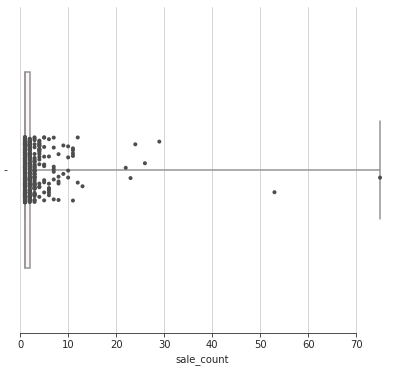

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 6))

sns.boxplot(x= 'sale_count', data=df,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x= 'sale_count', data=df,
              size=4, color=".3", linewidth=0) 

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

* 38位user中，發現有6位user所購買的商品在近一個月銷量>= 10，表示若僅提升38位用戶的推薦成效，仍建議使用rule-base會有較佳成效

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


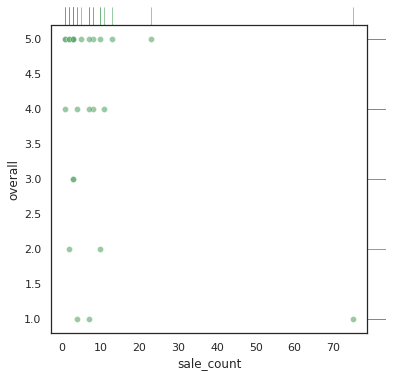

In [59]:
import seaborn as sns
sns.set_theme(style="white", color_codes=True)
mpg = sns.load_dataset("mpg")

# Use JointGrid directly to draw a custom plot
g = sns.JointGrid(data=asin_2_sale_count_38user, x="sale_count", y="overall", space=0, ratio=17)
g.plot_joint(sns.scatterplot, sizes=(60, 120),
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g", alpha=.6)

In [60]:
asin_2_sale_count_38user[asin_2_sale_count_38user['sale_count']>=10]

,asin,reviewerID,overall,unixReviewTime,DATE,sale_count
240463,B01DKQAXC0,A2M4YSOJZELJ6N,1.0,1536278400,2018-09-07,75.0
346958,B018WCT01C,A1WSZED2O5MA5T,5.0,1536883200,2018-09-14,13.0
347568,B0195R1FT8,A28E3FNV1BYC94,5.0,1536451200,2018-09-09,23.0
359679,B01DDQXRWU,ATJRZUXNWAWIK,4.0,1536624000,2018-09-11,11.0
364129,B01ES87TOY,AITF34BGBMVJJ,5.0,1536192000,2018-09-06,10.0
364131,B01ES87TOY,AGRZQOBCF8H87,2.0,1536019200,2018-09-04,10.0


#### Conclusion

* item-based推薦準度為0.169%
* item-based可進行推薦的基礎，主要建構於該商品有被評價，並同時與其他商品被用戶評價的前提下才能成立，依照資料集EDA，因為有部份產品僅購買一次並未被其他user同時購買其他產品，導致推薦成效不佳
* 另外有38位用戶中，其購買之產品有部分主要為近一個月熱銷品，因此使用rule-based表現更佳

## Surprise：產生推薦

In [61]:
!pip install surprise

In [62]:
ratings_trainings = ratings[
    (ratings['DATE'] >= '2017-09-01') & 
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [63]:
import time
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic

def recommender(training_data, users=[], k=10, user_based=False, algo=KNNBasic):

    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )

    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            recommend_items_iid = algo_impl.get_neighbors(iid, k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            if len(recommend_item_list) >= k:
                recommend_item_list = recommend_item_list[:k]
                break
        recommendation[user] = recommend_item_list

    return recommendation

ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

Computing the cosine similarity matrix...
Done computing similarity matrix.


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': ['B019Z9L2SK',
  'B015DZXQKC',
  'B00KOJA6

## Surprise：結果評估

In [64]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
            if len(set(ratings_by_user[d])) > 0:
                if len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))> 0:
                    print(f'user: {d} , Match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()
                else: 
                    print(f'user: {d} , Not match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()

    score = total / len(ratings_testings)
    return score

score = evaluate(ratings_testings_by_user, ratings_by_user)
print(f"The evaluation result is {score}")

user: A19503XX7GU6J2 , Not match!!!
recommendation:  ['B019Z9L2SK', 'B015DZXQKC', 'B00KOJA6HO', 'B019Z9JUC0', 'B019Z9L30W', 'B019Z9L6MC', 'B019Z9L8PW', 'B01DJI7796', 'B01G53GFKO', 'B012Z7IHHI']
real buy:  ['B01CTQC9J2']

user: A1EY751AUVO5NZ , Not match!!!
recommendation:  ['B01C74U1UU', 'B01254XUXW', 'B00AJECD2A', 'B01F6ENUK6', 'B01DJI7796', 'B01G53GFKO', 'B017BJ8KFE', 'B014KEITCC', 'B01DKQAXC0', 'B01HEYYRIK']
real buy:  ['B01E54U1RI']

user: A1TP9JHTIY468V , Not match!!!
recommendation:  ['B01DJI7796', 'B01G53GFKO', 'B017BJ8KFE', 'B014KEITCC', 'B01DKQAXC0', 'B01HEYYRIK', 'B014I56NSU', 'B01CW24JXC', 'B01DAP3H88', 'B017M402PO']
real buy:  ['B01CT5SNQQ']

user: A29834GBB4DOP1 , Not match!!!
recommendation:  ['B01DJI7796', 'B01G53GFKO', 'B017BJ8KFE', 'B014KEITCC', 'B01DKQAXC0', 'B01HEYYRIK', 'B014I56NSU', 'B01CW24JXC', 'B01DAP3H88', 'B017M402PO']
real buy:  ['B01G00BHN2']

user: A2BU6N5956T9NH , Not match!!!
recommendation:  ['B018WCT01C', 'B0189NOD4I', 'B0178LU0Y4', 'B00ZR3UP50', 'B00VF

In [65]:
print(f'{len([user for user in ratings_by_user if len(ratings_by_user[user])>0 ])} users have recommendations')

13 users have recommendations


#### Conclusion

surprise使用感覺更吃資源，另因受限主要新用戶過多、user購買次數低，導致其推薦表現上為0.169%，僅成功推薦一位user